# Open log file

In [173]:
import json
from tqdm import tqdm


def read_log():
    log_data_list = []
    error_line_total = 0
    
    with open("../../preprocessed_log.jsonl", "r") as f:
        for line in tqdm(list(f)):
            
            # 此处未知原因存在行不是json的情况，大约占比10%          
            try:
                log_data_list.append(json.loads(line))
            except:
                error_line_total+=1
        print(f"error line number is {error_line_total}")
        
    return log_data_list

In [113]:
log_data = read_log()
log_data[0]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3042725/3042725 [00:05<00:00, 573362.40it/s]

error line number is 31111


{'record': '615937',
 'lang': 'zh',
 'page': '0',
 'reason': 'line_freq: 11, pages: 11',
 'filtered': '联合国 E/CN.3/2008/1'}

# view filtered information for record

In [114]:
def print_record_filtered_information(record, log_data):
    log_data = filter(lambda row:int(row["record"]) == record, log_data)
    for row in sorted(log_data, key=lambda x: x['reason']):
        print("=============================================================")
        print()
        print(f"lang => {row['lang']}")
        print()
        print(f"reason => {row['reason']}")
        print()
        print(f"filtered str => {row['filtered']}")
        print()

In [115]:
print_record_filtered_information(544851, log_data)


lang => zh

reason => annotation block

filtered str => ____________________________ 
* 本摘要汇编使用了《贸易法委员会法规的判例法》（《法规的判例法》）摘要中所引用的
判决书全文和脚注中所列的其他引文。这些摘要原意仅作为基本判决提要，可能不反映汇
编中表述的所有观点。建议读者查阅所列法院判决书和仲裁裁决书全文，而不只依靠《法
规的判例法》摘要。
V.04-54724 
联合国国际贸易法委员会 
贸易法委员会关于《联合国国际货物销售合同公约》 
判例法摘要汇编*
第二条 
本公约不适用于以下的销售： 
(a) 购供私人、家人或家庭使用的货物的销售，除非卖方在订立合同前
任何时候或订立合同时不知道而且没有理由知道这些货物是购供
任何这种使用； 
(b) 经由拍卖的销售； 
(c) 根据法律执行令状或其它令状的销售； 
(d) 公债、股票、投资证券、流通票据或货币的销售； 
(e) 船舶、船只、气垫船或飞机的销售； 
(f) 电力的销售。 


lang => fr

reason => annotation block

filtered str => _______________ 
 * Le présent Précis de jurisprudence a été établi à partir du texte intégral des décisions citées dans 
les sommaires des Recueils de jurisprudence concernant les textes de la CNUDCI et d'autres 
décisions mentionnées dans les notes. Ces sommaires n'étant par définition que des résumés de 
décisions, ils ne rendent pas nécessairement compte de tous les points examinés dans le Précis, 
et il est donc conseillé au lecteur de consulter également le texte

# Count the number of filters for each record

In [116]:
def count_record_filters_total(log_data):
    filted_record_reason = {}

    for row in filted_data_list:
        if not row["record"] in filted_record_reason:
            filted_record_reason[row["record"]] = {}

        reason = row["reason"].split(",")[0].split(": ")[0]

        if reason in filted_record_reason[row["record"]]:
            filted_record_reason[row["record"]][reason] += 1
        else:
            filted_record_reason[row["record"]][reason] = 1
            
    return filted_record_reason

In [117]:
filted_record_reason = count_record_filters_total(log_data)
filted_record_reason["544851"]

{'line_freq': 8, 'annotation block': 13, 'overall_tk_freq': 1}

# Calculate filters total

In [148]:
reason_total = {}

for record in filted_data_record_map:
    for reason in filted_data_record_map[record]:
        if reason in reason_total:
            reason_total[reason] += filted_data_record_map[record][reason]
        else:
            reason_total[reason] = 0

In [149]:
reason_total

{'line_freq': 759560,
 'annotation block': 55272,
 'overall_tk_freq': 153936,
 'tk_freq': 70140,
 'likely page number': 215421}

# Calculate filters line total

In [120]:
def count_record_filters_line_total(log_data):
    filted_record_reason_line_total = {}

    for row in log_data:
        if not row["record"] in filted_record_reason:
            filted_record_reason[row["record"]] = {}

        reason = row["reason"].split(",")[0].split(": ")[0]
        if reason in filted_record_reason_line_total:
            filted_record_reason_line_total[reason] += len(row["filtered"].split("\n"))
        else:
            filted_record_reason_line_total[reason] = len(row["filtered"].split("\n"))
    
    return filted_record_reason_line_total

In [143]:
import pandas as pd

filted_record_reason_line_total = count_record_filters_line_total(log_data)

filted_record_reason_line_total["total"] = sum([filted_record_reason_line_total[reason] for reason in filted_record_reason_line_total])

df = pd.DataFrame.from_dict(filted_record_reason_line_total, orient='index', columns=['Lines count'])
df = df.rename_axis('Reason').reset_index()
df

,Reason,Lines count
0,line_freq,1817599
1,overall_tk_freq,372874
2,annotation block,899462
3,tk_freq,165451
4,likely page number,522076
5,total,3777462


# Frequency graph

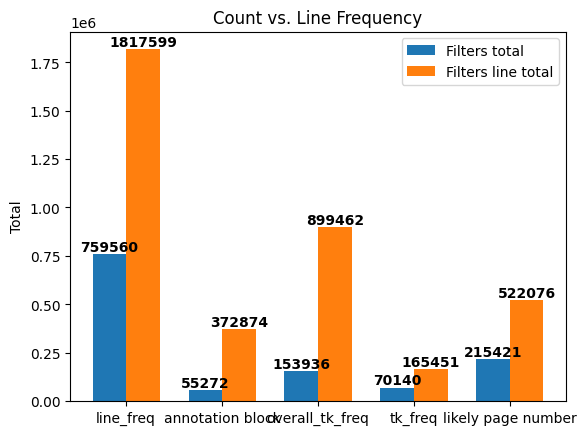

In [174]:
import matplotlib.pyplot as plt

filted_record_reason_line_total_copy = filted_record_reason_line_total
filted_record_reason_line_total_copy.pop("total", None)

labels = list(reason_total.keys())

filters_total_value = list(reason_total.values())
filters_line_total_value = list(filted_record_reason_line_total_copy.values())

fig, ax = plt.subplots()

width = 0.35

ax.bar(labels, filters_total_value, width, label='Filters total')

ax.bar([x + width for x in range(len(labels))], filters_line_total_value, width, label='Filters line total')

ax.set_ylabel('Total')
ax.set_title('Count vs. Line Frequency')

ax.set_xticks([x + width/2 for x in range(len(labels))])


for i, v in enumerate(filters_total_value):
    ax.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

for i, v in enumerate(filters_line_total_value):
    ax.text(i + width, v, str(v), ha='center', va='bottom', fontweight='bold')


ax.legend()
plt.show()